<a href="https://colab.research.google.com/github/elenipapadopoulou4/thesis-code/blob/main/ValenceArousal_Estimation_AFEWVA_data_augmentation_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train RESNET network on AFEW-VA dataset for Valence & Arousal 

Τα valence και arousal είναι συνεχείς και λαμβάνουν τιμές απο [-1,1]  <br>


valence -- > δείχνει πόσο θετικό/αρνητικό είναι το συναίσθημα που απεικονίζεται

arousal -- > δείχνει πόσο ενεργητική/παθητική είναι η συναισθηματική κατάσταση

In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
import tensorflow as tf

import os 
import matplotlib.pyplot as plt

import numpy as np
from tabulate import tabulate


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout


from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint 

import matplotlib.image as mpimg

from keras.models import model_from_json
import json

from keras import backend as K

import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr

import statistics

import joblib

import scipy

import pickle


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip  /content/gdrive/MyDrive/train_net/datasets/AFEW-VA/AFEW-VA_aligned.zip -d /content

In [ ]:
dataset_path = '/content/AFEW-VA_aligned'
annotations_path = '/content/AFEW-VA_aligned/afew_va_annots.txt'
ff_outputs = '/content/gdrive/MyDrive/train_net/FairFace/AFEW-VA_outputs.csv'

## Create dataframe

FairFace outputs

In [ ]:
df_ff =  pd.read_csv(ff_outputs)
df_ff = df_ff.drop(['race','race_scores_fair','race_scores_fair_4','gender_scores_fair','age_scores_fair'],axis=1)
df_ff = df_ff.rename(columns={"race4": "race"})


In [ ]:
#avoid double values  
#rename with directory path
paths = [] #list with all names of paths
for i, row in enumerate(df_ff['face_name_align']):
  dir_image = (row[row.rfind('/')+1:row.rfind('face')-1])+'.jpg'
  dir = dir_image[:dir_image.find('_')]
  image = dir_image[dir_image.find('_')+1:]
  path_name = os.path.join(dataset_path,dir,image)

  if (path_name in paths):
     df_ff.drop([i], axis=0, inplace=True)
  else:
     df_ff['face_name_align'][i] = path_name
     paths.append(path_name)

annotations

In [ ]:
# read annotations txt and convert to pandas dataframe
df =  pd.read_csv(annotations_path,sep=" ",header=None)
df.columns =['face_name_align', 'valence', 'arousal']

In [ ]:
for i, row in df.iterrows():
  image_path = df['face_name_align'][i][-13:]
  df.loc[i,'face_name_align'] = os.path.join(dataset_path,image_path)


In [ ]:
df_all = (pd.merge(df, df_ff, on='face_name_align'))
print("lenght of  data",len(df_all))


# Before Split

In [ ]:
#joblib.dump(df_all,'/content/gdrive/MyDrive/train_net/afewva_df_all')
df_all = joblib.load('/content/gdrive/MyDrive/train_net/afewva_df_all')


In [ ]:
df_all

,face_name_align,valence,arousal,race,gender,age
0,/content/AFEW-VA_aligned/001/00000.jpg,0.0,0.5,White,Male,20-29
1,/content/AFEW-VA_aligned/001/00001.jpg,0.0,0.5,White,Male,20-29
2,/content/AFEW-VA_aligned/001/00002.jpg,0.0,0.5,White,Male,20-29
3,/content/AFEW-VA_aligned/001/00003.jpg,0.0,0.5,White,Male,20-29
4,/content/AFEW-VA_aligned/001/00004.jpg,0.0,0.5,White,Male,20-29
...,...,...,...,...,...,...
12152,/content/AFEW-VA_aligned/241/00084.jpg,0.2,0.3,White,Male,20-29
12153,/content/AFEW-VA_aligned/241/00085.jpg,0.2,0.3,White,Male,20-29
12154,/content/AFEW-VA_aligned/241/00086.jpg,0.2,0.3,White,Male,20-29
12155,/content/AFEW-VA_aligned/241/00087.jpg,0.2,0.3,White,Male,20-29


In [ ]:
#create video column
def get_video_from_filename(row):
    filename = row['face_name_align']
    video_name = (filename[filename.find('/',10)+1:filename.find('/',10)+4])
    return video_name
#create frames column
def add_frames(row):
  for video,num_frames in frames.items():
    if row['video'] == video:
      return num_frames


In [ ]:
df_all['video'] = df_all.apply(lambda row: get_video_from_filename(row), axis=1)
frames = ((df_all.groupby(['video']).count())['face_name_align']).to_dict()
df_all['frames'] = df_all.apply(lambda row: add_frames(row), axis=1)


In [ ]:
all_videos = df_all.video.unique()


In [ ]:
len(all_videos)

246

In [ ]:
#keep RACE-GENDER-AGE values the same for each video
all_videos = df_all.video.unique()
for video in all_videos:

  #find most frequent value for each category

  gender = df_all[df_all.video == video]['gender'].mode()[0]
  race = df_all[df_all.video == video]['race'].mode()[0]
  age = df_all[df_all.video == video]['age'].mode()[0]
  
  
  #replace all values with most frequent
  df_all.loc[df_all.video == video,'gender'] = gender
  df_all.loc[df_all.video == video,'race'] = race
  df_all.loc[df_all.video == video,'age'] = age




##Show data

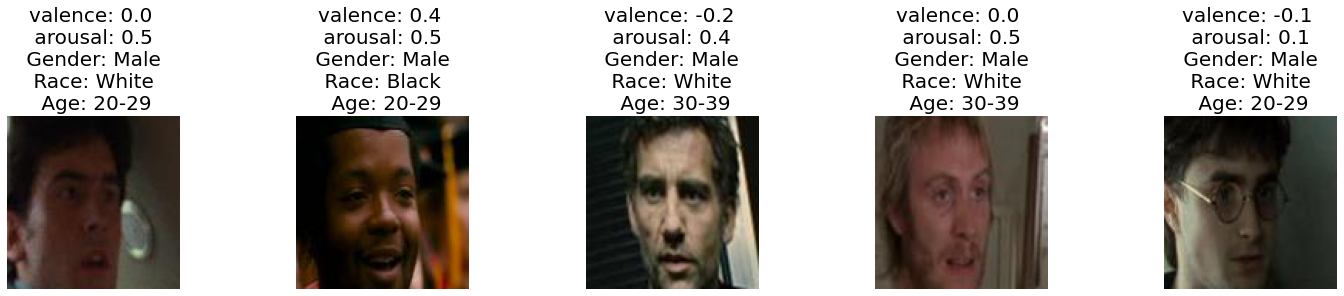

In [ ]:
num_images = 5
fig, axs = plt.subplots(figsize=(20, 4), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  index = i+i*100
  image  =  mpimg.imread(df_all['face_name_align'][i+i*100])
  axs[i].imshow(image)  
  axs[i].set_title('valence: {} \n arousal: {} \n Gender: {} \n Race: {} \n Age: {}'.format(df_all['valence'][index],df_all['arousal'][index],
                                                                                            df_all['gender'][index],df_all['race'][index],df_all['age'][index]),fontsize = 20)
  axs[i].axis("off")



## train-validation-test split

In [ ]:
def show_v_a_distribution_one(df):
  fig,axs = plt.subplots(figsize =(7, 5),ncols=1)
  x= df['arousal']
  y = df['valence']
  plt.hist2d(x, y,range =  [[-1, 1], [-1, 1]])
  plt.xlabel('arousal', fontsize=12)
  plt.ylabel('valence', fontsize=12)
  plt.title("Distribution of all data", fontsize=15)
  plt.colorbar()

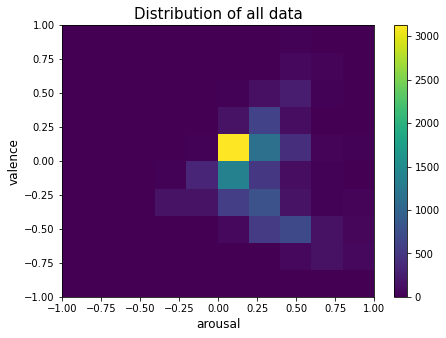

In [ ]:
show_v_a_distribution_one(df_all)

In [ ]:
aggregation_functions = {'gender': 'first', 'race': 'first', 'age': 'first','video':'first','frames':'first'}
df_videos = df_all.groupby(df_all['video']).aggregate(aggregation_functions)

In [ ]:
df_videos

,gender,race,age,video,frames
video,,,,,
001,Male,White,20-29,001,42
002,Male,White,30-39,002,58
003,Female,White,20-29,003,39
004,Male,White,40-49,004,21
005,Male,White,20-29,005,18
...,...,...,...,...,...
242,Male,White,40-49,242,86
243,Female,White,20-29,243,33
244,Female,White,30-39,244,57


Χωρίζω τυχαία τα βίντεο μέχρι να βρώ μια καλή κατανομή

In [ ]:
def train_val_test_video(category):
  category = category.sample(frac=1).reset_index(drop=True)

  len_list = len(category)
  train_per = int(len_list*0.55)
  val_per = int(len_list*0.15)
  test_per = int(len_list*0.30)
  
  train_category = list(category['video'][:train_per])
  val_category = list(category['video'][train_per:train_per+val_per])
  test_category = list(category['video'][train_per+val_per:])

  return train_category,val_category,test_category



In [ ]:
train_random,val_random,test_random = train_val_test_video(df_videos)

In [ ]:
df_train= df_all[df_all['video'].isin(train_random)].reset_index(drop=True)
df_validation = df_all[df_all['video'].isin(val_random)].reset_index(drop=True)
df_test = df_all[df_all['video'].isin(test_random)].reset_index(drop=True)

In [ ]:
#joblib.dump(df_train,'/content/gdrive/MyDrive/train_net/afewva/df_train')
#joblib.dump(df_validation,'/content/gdrive/MyDrive/train_net/afewva/df_validation')
#joblib.dump(df_test,'/content/gdrive/MyDrive/train_net/afewva/df_test')

df_train= joblib.load('/content/gdrive/MyDrive/train_net/afewva/df_train')
df_validation= joblib.load('/content/gdrive/MyDrive/train_net/afewva/df_validation')
df_test= joblib.load('/content/gdrive/MyDrive/train_net/afewva/df_test')

## data distribution

In [ ]:
def show_v_a_distribution(df_train,df_val,df_test):
 
  sets = ['train','validation','test']
  fig,axs = plt.subplots(figsize =(18, 5),ncols=3) 
  fig.suptitle('BEFORE split', fontsize=10)
  for i,df in enumerate([df_train,df_val,df_test]):
    x = df['arousal']
    y = df['valence']
    hist = axs[i].hist2d(x, y,range =  [[-1, 1], [-1, 1]])
    axs[i].set_xlabel('arousal', fontsize=12)
    axs[i].set_ylabel('valence', fontsize=12)
    axs[i].set_title("Distribution of {} set".format(sets[i]), fontsize=15)
    fig.colorbar(hist[3], ax=axs[i])


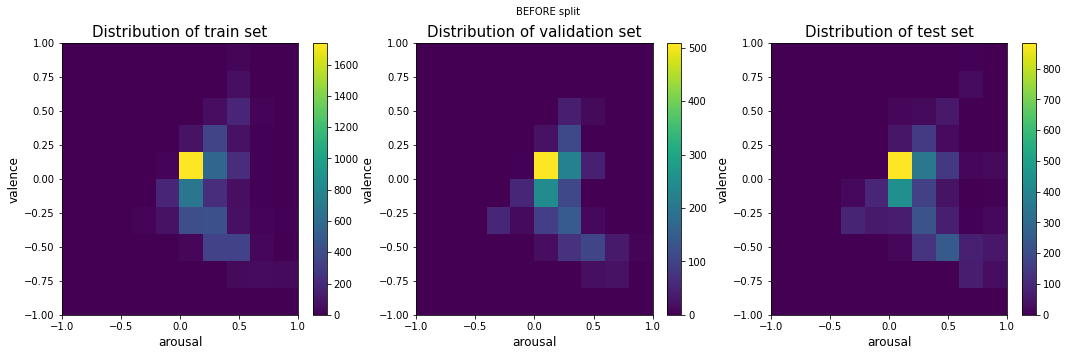

In [ ]:
show_v_a_distribution(df_train,df_validation,df_test)

In [ ]:
def plot_samples(category,names,train_counter,val_counter,test_counter):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
  fig.suptitle('Database: AFEWVA\nTask: valence and arousal estimation \nBEFORE split', fontsize=15)
  sets = ['train','validation','test']
  for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
    names_list = [name for name in names]
    axs[i].bar(names_list,set_counter,color='c',  edgecolor='black')
    axs[i].set_title("{} for {} set".format(category,sets[i]),fontsize=15)

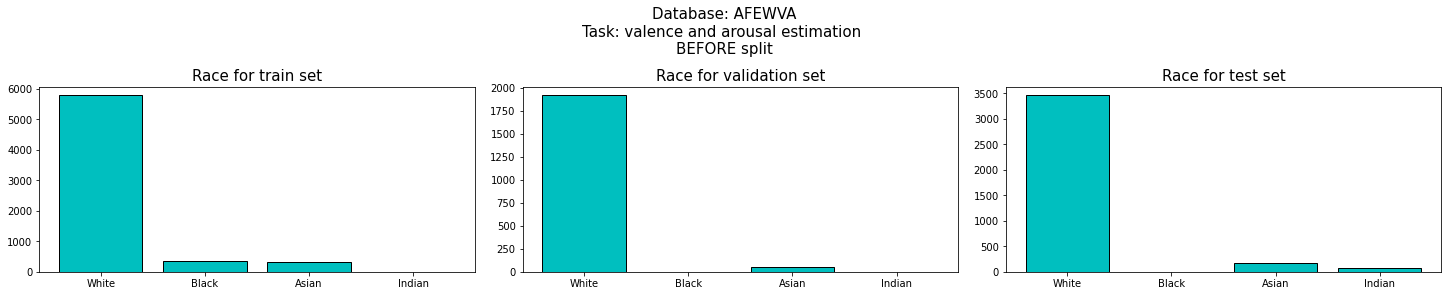

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train[df_train['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_validation[df_validation['race']==race_names[i]]))

race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test[df_test['race']==race_names[i]]))

plot_samples('Race',race_names,race_counter_train,race_counter_val,race_counter_test)


In [ ]:
print(race_counter_train)
print(race_counter_val)
print(race_counter_test)

[5780, 370, 333, 0]
[1917, 0, 49, 0]
[3456, 0, 177, 75]


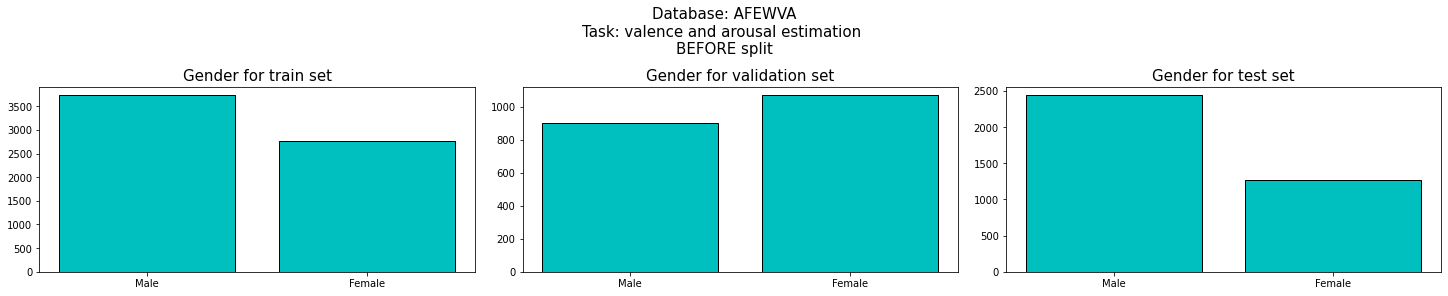

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train[df_train['gender']==gender_names[i]]))

gender_counter_val = []
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_validation[df_validation['gender']==gender_names[i]]))

gender_counter_test = []
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test[df_test['gender']==gender_names[i]]))

plot_samples('Gender',gender_names,gender_counter_train,gender_counter_val,gender_counter_test)


In [ ]:
print(gender_counter_train)
print(gender_counter_val)
print(gender_counter_test)

[3728, 2755]
[898, 1068]
[2439, 1269]


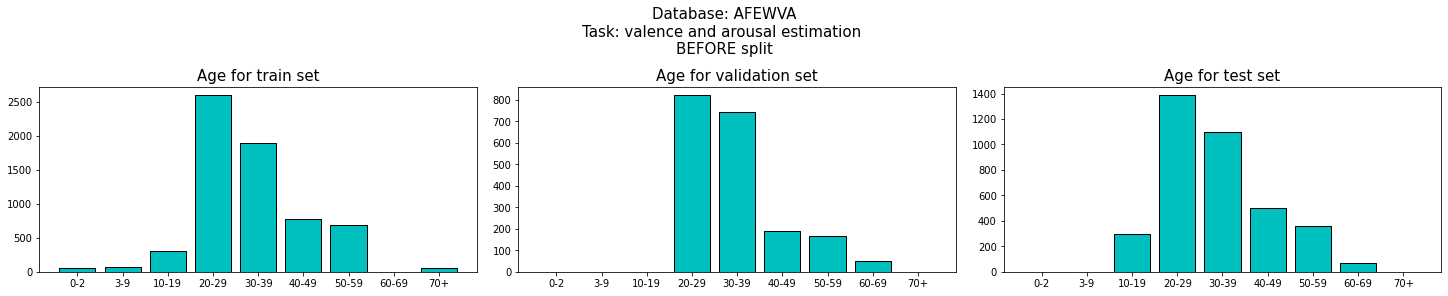

In [ ]:

age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train[df_train['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_validation[df_validation['age']==age_names[i]]))

age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test[df_test['age']==age_names[i]]))

plot_samples('Age',age_names,age_counter_train,age_counter_val,age_counter_test)


In [ ]:
print(age_counter_train)
print(age_counter_val)
print(age_counter_test)

[61, 77, 312, 2597, 1903, 784, 690, 0, 59]
[0, 0, 0, 820, 742, 189, 166, 49, 0]
[0, 0, 297, 1385, 1099, 500, 357, 70, 0]


## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_all['face_name_align'][30])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(112, 112, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 112*112 και είναι έγχρωμες (τιμές απο 0-255). <br>
 Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 112 * 112 * 3. 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])

In [ ]:
#drop some rows to have samplesMODbatch==0
df_train.drop(df_train.index[0:19], axis=0, inplace=True)
df_validation.drop(df_validation.index[0:14], axis=0, inplace=True)

In [ ]:
batch_size = 64
#load and iterate training dataset
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='face_name_align',
    y_col=['valence','arousal'], #multitask
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw', #regression
    batch_size=batch_size
)
# load and iterate validation dataset
validation_generator = test_datagen.flow_from_dataframe(
    df_validation,
    x_col='face_name_align',
    y_col=['valence','arousal'],
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
)

# load and iterate test dataset
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='face_name_align',
    y_col=['valence','arousal'],
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle = False
)


Found 6464 validated image filenames.
Found 1952 validated image filenames.
Found 3708 validated image filenames.


## training

In [ ]:
#correlation coef loss function
def concordance_cc2(predictions,labels):
    pred_mean, pred_var = tf.nn.moments(predictions, (0,))
    gt_mean, gt_var = tf.nn.moments(labels, (0,))

    mean_cent_prod = tf.reduce_mean((predictions - pred_mean) * (labels - gt_mean))

    return 1 - (2 * mean_cent_prod) / (pred_var + gt_var + tf.square(pred_mean - gt_mean))




In [ ]:
def concordance_cc2_loss(labels,predictions):
  #split valence and arousal values
  labels_valence = labels[:,0]  
  predictions_valence = predictions[:,0]

  
  labels_arousal = labels[:,1]
  predictions_arousal = predictions[:,1]

  return ( concordance_cc2(predictions_valence, labels_valence) + concordance_cc2(predictions_arousal, labels_arousal) ) / 2 



In [ ]:
#pretrained model 
base_model =  tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_shape=(112,112,3),
    pooling='avg',
)

#use functional API to allow multiple outputs
# input shape
inputs = tf.keras.Input(shape=(112, 112, 3))
# model architecture
x = base_model(inputs, training=True)
#x = Dense(512, activation="relu")(x)
#x = Dropout(0.2)(x)
#x = Dense(512,activation= "relu")(x)

#output --> 2 tasks: valence & arousal
outputs = tf.keras.layers.Dense(2,activation="linear")(x) #change to tanh and see results
model = tf.keras.Model(inputs, outputs)
  

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.001),
                     loss= concordance_cc2_loss) 
                     # metrics=['mae',pearson_r] mean absolute error, Pearsons Correlation Coefficient

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/AFEW-VA/AFEW-VA_simple/AFEWVA_before_lr3_b64_aug/AFEWVA-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


## evaluation


In [ ]:
RACES =['White','Black','Asian','Indian']
AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
GENDERS = ['Male','Female']

In [ ]:
#new correlation coef
def concordance_cc2_eval(r1, r2): #r1,r2 = labels,predictions
     mean_cent_prod = np.mean((r1 - np.mean(r1)) * (r2 - np.mean(r2)))
     return (2 * mean_cent_prod) / (np.var(r1) + np.var(r2) + (np.mean(r1) - np.mean(r2)) ** 2)


In [ ]:
def correlation_mse_mae(labels,predictions):
  correlation = concordance_cc2_eval(labels, predictions)
  mse = mean_squared_error(labels, predictions)
  mae = mean_absolute_error(labels, predictions)
  return (correlation,mse,mae)




In [ ]:
def predictions_labels_category(test_generator,df_test,labels,predictions,category_list,category_name):
  y_pred = {key: [] for key in category_list}
  y_true = {key: [] for key in category_list}
  category_counter = {key: [] for key in category_list} # values are list of indexes of each category

  for i,name in enumerate(test_generator.filenames): 
    category_filename = df_test.loc[df_test['face_name_align'] == name, category_name].item()
    for cat in category_list:
      if category_filename == cat:
        category_counter[cat].append(i)
        y_pred[cat].append(predictions[i])
        y_true[cat].append(labels[i])
    
  return y_true,y_pred,category_counter

In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/AFEW-VA/AFEW-VA_simple/AFEWVA_before_lr3_b128'
for saved_model in (os.listdir(models_directory)):
  print(saved_model)
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model),custom_objects={'concordance_cc2_loss':concordance_cc2_loss})
  models_labels[saved_model[:-3]] = test_generator.labels
  models_predictions[saved_model[:-3]] = model.predict(test_generator)


AFEWVA-01.h5
AFEWVA-02.h5
AFEWVA-03.h5
AFEWVA-04.h5
AFEWVA-05.h5
AFEWVA-06.h5
AFEWVA-07.h5
AFEWVA-08.h5
AFEWVA-09.h5
AFEWVA-10.h5


In [ ]:
def valence_arousal(labels,predictions):
  valence_labels= []
  valence_predictions = []
  arousal_labels = []
  arousal_predictions = []

  for (v_l,a_l),(v_p,a_p) in zip(labels,predictions):
    valence_labels.append(v_l)
    valence_predictions.append(v_p)
    arousal_labels.append(a_l)
    arousal_predictions.append(a_p)

  return valence_labels,valence_predictions,arousal_labels,arousal_predictions

In [ ]:
for model_name in models_labels.keys():
  
  valence_labels= []
  valence_predictions = []
  arousal_labels = []
  arousal_predictions = []

  labels,predictions = models_labels[model_name],models_predictions[model_name]
  valence_labels,valence_predictions,arousal_labels,arousal_predictions = valence_arousal(labels,predictions)

  print("Model Name: =",model_name)
  correlation_v,mse_v,mae_v = correlation_mse_mae(valence_labels,valence_predictions)
  correlation_a,mse_a,mae_a = correlation_mse_mae(arousal_labels,arousal_predictions)
  data = [["Correlation",correlation_v,correlation_a],["Mean Squared Error",mse_v,mse_a],["Mean Absolute Error",mae_v,mae_a]]
  print(tabulate(data, headers=[" Valence","Arousal"]))
  print('\n\n')

In [ ]:
best_model_name = 'AFEWVA-08'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)),custom_objects={'concordance_cc2_loss':concordance_cc2_loss})


In [ ]:
y_true_race,y_pred_race,counter_race = predictions_labels_category(test_generator,df_test,
                                                      models_labels[best_model_name],models_predictions[best_model_name],
                                                      RACES,'race')

y_true_age,y_pred_age,counter_age = predictions_labels_category(test_generator,df_test,
                                                    models_labels[best_model_name],models_predictions[best_model_name],
                                                    AGES,'age')

y_true_gender,y_pred_gender,counter_gender = predictions_labels_category(test_generator,df_test,
                                                          models_labels[best_model_name],models_predictions[best_model_name],
                                                          GENDERS,'gender')


In [ ]:
#give indexes of category and out
def indexes_to_videos(df_test,counter):
  videos = df_test.video.unique()
  videos_counter = []
  for i in counter:
    video = df_test.iloc[i]['video']
    videos_counter.append(video)
  return videos_counter


In [ ]:
def results_category(df_test,split,category_list,category_name,y_true,y_pred,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for i,cat in enumerate(category_list):
    if len(y_true[cat])!= 0:
      v_l,v_p,a_l,a_p = valence_arousal(y_true[cat],y_pred[cat])
      data.append([cat, 
                 len(np.unique(indexes_to_videos(df_test,category_counter[cat]))),
                 len(category_counter[cat]),
                 correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0],
                 correlation_mse_mae(v_l,v_p)[2],correlation_mse_mae(a_l,a_p)[2]])
    else:
      data.append([cat,'Nan','Nan','Nan','Nan','Nan','Nan'])
  print(tabulate(data, headers=[category_name, 
                                "#videos",
                                "#frames",
                                "Correlation\nValence",
                                "Correlation\nArousal",
                                "Mean Absolute Error\nValence",
                                "Mean Absolute Error\nArousal"]))
  print()



In [ ]:
def results_category_nomse(df_test,split,category_list,category_name,y_true,y_pred,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for i,cat in enumerate(category_list):
    if len(y_true[cat])!= 0:
      v_l,v_p,a_l,a_p = valence_arousal(y_true[cat],y_pred[cat])
      data.append([cat, 
                 len(np.unique(indexes_to_videos(df_test,category_counter[cat]))),
                 len(category_counter[cat]),
                 correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0]])
    else:
      data.append([cat,'Nan','Nan','Nan','Nan'])
  print(tabulate(data, headers=[category_name, 
                                "#videos",
                                "#frames",
                                "Correlation\nValence",
                                "Correlation\nArousal"]))
  print()



In [ ]:
print("OVERALL scores before split")
print("Batch size = 64 , learning rate = 0.001")
labels,predictions = models_labels[best_model_name],models_predictions[best_model_name]
v_l,v_p,a_l,a_p = valence_arousal(labels,predictions)
data = [["Pearsons Correlation",correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0]]]
print(tabulate(data, headers=[" Valence","Arousal"]))
print()
results_category_nomse(df_test,'before',RACES,'race',y_true_race,y_pred_race,counter_race)
results_category_nomse(df_test,'before',AGES,'age',y_true_age,y_pred_age,counter_age)
results_category_nomse(df_test,'before',GENDERS,'gender',y_true_gender,y_pred_gender,counter_gender)


OVERALL scores before split
Batch size = 64 , learning rate = 0.001
                         Valence    Arousal
--------------------  ----------  ---------
Pearsons Correlation    0.211088   0.164935

race scores before split
race      #videos    #frames    Correlation    Correlation
                                    Valence        Arousal
------  ---------  ---------  -------------  -------------
White          69       3456     0.197205         0.166289
Black         nan        nan   nan              nan
Asian           3        177     0.319197         0.174179
Indian          3         75     0.00118344      -0.292279

age scores before split
age      #videos    #frames    Correlation    Correlation
                                   Valence        Arousal
-----  ---------  ---------  -------------  -------------
0-2          nan        nan    nan            nan
3-9          nan        nan    nan            nan
10-19          6        297      0.202812      -0.0317615
20-29      

#After split

In [ ]:
RACES =['White','Black','Asian','Indian']
AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
GENDERS = ['Male','Female']

In [ ]:
df_all

,face_name_align,valence,arousal,race,gender,age,video,frames
0,/content/AFEW-VA_aligned/001/00000.jpg,0.0,0.5,White,Male,20-29,001,42
1,/content/AFEW-VA_aligned/001/00001.jpg,0.0,0.5,White,Male,20-29,001,42
2,/content/AFEW-VA_aligned/001/00002.jpg,0.0,0.5,White,Male,20-29,001,42
3,/content/AFEW-VA_aligned/001/00003.jpg,0.0,0.5,White,Male,20-29,001,42
4,/content/AFEW-VA_aligned/001/00004.jpg,0.0,0.5,White,Male,20-29,001,42
...,...,...,...,...,...,...,...,...
12152,/content/AFEW-VA_aligned/241/00084.jpg,0.2,0.3,White,Male,20-29,241,89
12153,/content/AFEW-VA_aligned/241/00085.jpg,0.2,0.3,White,Male,20-29,241,89
12154,/content/AFEW-VA_aligned/241/00086.jpg,0.2,0.3,White,Male,20-29,241,89
12155,/content/AFEW-VA_aligned/241/00087.jpg,0.2,0.3,White,Male,20-29,241,89


In [ ]:
aggregation_functions = {'gender': 'first', 'race': 'first', 'age': 'first','video':'first','frames':'first'}
df_videos = df_all.groupby(df_all['video']).aggregate(aggregation_functions)

In [ ]:
df_videos

,gender,race,age,video,frames
video,,,,,
001,Male,White,20-29,001,42
002,Male,White,30-39,002,58
003,Female,White,20-29,003,39
004,Male,White,40-49,004,21
005,Male,White,20-29,005,18
...,...,...,...,...,...
242,Male,White,40-49,242,86
243,Female,White,20-29,243,33
244,Female,White,30-39,244,57


In [ ]:
#create bins directory
categories = []
for gender in GENDERS:
  for race in RACES:
    for age in AGES:
      categories.append(tuple((gender,race,age)))
bins = dict.fromkeys(categories)

#fill bins 
for gender in GENDERS:
  for race in RACES:
    for age in AGES:
      print("gender:",gender,"race:",race,"age:",age)
      bin = []
      for video in df_videos['video']:
        if ((df_videos.loc[df_videos.video ==	video,'gender'] == gender).bool() and 
                (df_videos.loc[df_videos.video ==	video,'race'] == race).bool() and 
                (df_videos.loc[df_videos.video ==	video,'age'] == age).bool()):
          bin.append(video)
      bins[(gender,race,age)] = bin
  

In [ ]:
# all frames of each bin
bin_frames_all = {}
# frames of each video
video_frames = {}
for bin,value in bins.items():
  bin_frames = []
  for video in value:
    frames = df_videos.loc[df_videos.video==video,'frames'].item()
    bin_frames.append(frames)
    video_frames[video] =frames
  bin_frames_all[bin] = sum(bin_frames)
  print("Bin: {} \nNumber of Videos: {} \nVideos: {}  \nFrames: {} \nFrames in bin: {}\n".format(bin,len(value),value,bin_frames,bin_frames_all[bin]))


In [ ]:
train_set_videos = ['057','156','199','045','033','182', '241', '054', '158', '083', '145', '017', '021', '153', '039', '204', '186', '076','008', '144', '206', '230', '098', '238', '200', '014', '147', '031', '088', '152', '082', '002', '127', '216','181', '242', '187', '174', '086', '165', '004','133', '215', '071', '070', '211', '212', '163', '052','055', '246','011', '178', '148', '154', '213', '099', '161', '137', '191', '073', '227', '220', '195', '111', '061', '067', '112', '048', '036', '053', '226', '131', '118', '201', '177', '175', '026', '244', '104','171', '236','050', '074', '218','084', '164', '168','035']

test_set_videos= ['092','058','149','185','022', '023', '024', '116', '094', '038', '172', '208', '001', '225', '235', '129', '020', '130', '117','134', '108', '096', '217', '051', '095', '188', '162', '194', '034', '193', '169', '068', '124', '090', '167', '069', '091', '128','016', '180', '179', '107', '232', '173', '047', '037','063','006','234','123','192','081','184','219', '089','239', '210', '135', '214', '114', '044', '119', '228', '151', '003', '007', '198', '159', '028', '240', '209', '043', '243', '245','221', '065', '101', '125', '010', '102', '062', '066', '097', '018', '132','113','120','121','025','106']

val_set_videos =  ['030','079','087', '140', '139', '041', '142', '029', '233', '077', '229', '080', '190', '005', '078', '231','049', '207', '203', '012', '138', '166', '222', '064', '224', '143', '237', '027','115', '146', '019', '183', '105', '110','197', '196', '040', '072', '060','160', '155', '046', '042', '103', '056', '126', '109', '009', '141', '223', '150', '032', '136', '059', '202','170', '189', '075', '015', '093', '205', '085', '176', '122','100','157','013']

In [ ]:
len(train_set_videos)+len(val_set_videos)+len(test_set_videos)

246

In [ ]:
len(train_set_videos),len(val_set_videos),len(test_set_videos)

(89, 67, 90)

In [ ]:
df_train_fair = df_all[df_all['video'].isin(train_set_videos)].reset_index(drop=True)
df_validation_fair = df_all[df_all['video'].isin(val_set_videos)].reset_index(drop=True)
df_test_fair = df_all[df_all['video'].isin(test_set_videos)].reset_index(drop=True)

In [ ]:
def show_v_a_distribution(df_train,df_val,df_test):
 
  sets = ['train','validation','test']
  fig,axs = plt.subplots(figsize =(18, 5),ncols=3) 
  fig.suptitle('AFTER split', fontsize=10)
  for i,df in enumerate([df_train,df_val,df_test]):
    x = df['arousal']
    y = df['valence']
    hist = axs[i].hist2d(x, y,range =  [[-1, 1], [-1, 1]])
    axs[i].set_xlabel('arousal', fontsize=12)
    axs[i].set_ylabel('valence', fontsize=12)
    axs[i].set_title("Distribution of {} set".format(sets[i]), fontsize=15)
    fig.colorbar(hist[3], ax=axs[i])


In [ ]:
def plot_samples(category,names,train_counter,val_counter,test_counter):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
  fig.suptitle('Database: AFEWVA\nTask: valence and arousal estimation \nAFTER split', fontsize=15)
  sets = ['train','validation','test']
  for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
    names_list = [name for name in names]
    axs[i].bar(names_list,set_counter,color='c',  edgecolor='black')
    axs[i].set_title("{} for {} set".format(category,sets[i]),fontsize=15)

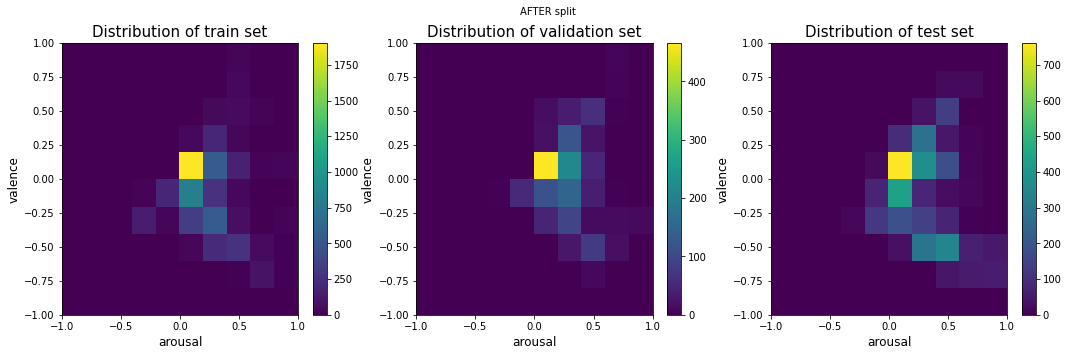

In [ ]:
show_v_a_distribution(df_train_fair,df_validation_fair,df_test_fair)

## data distribution

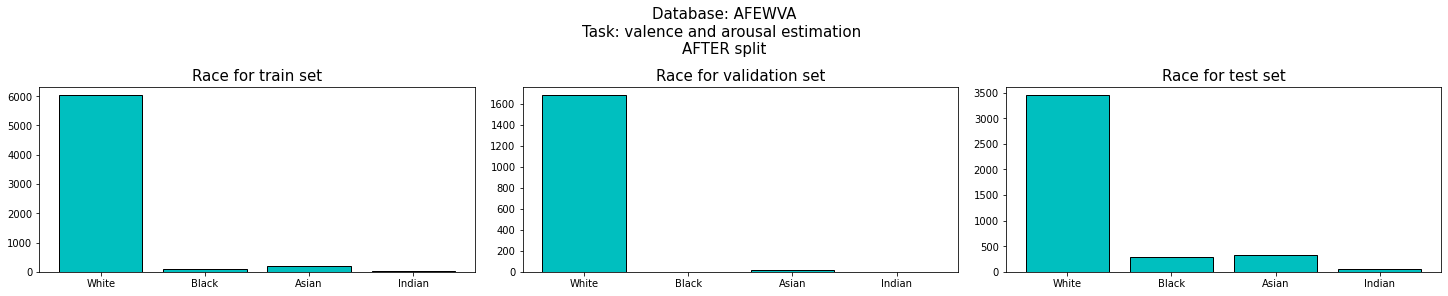

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train_fair[df_train_fair['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_validation_fair[df_validation_fair['race']==race_names[i]]))

race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test_fair[df_test_fair['race']==race_names[i]]))

plot_samples('Race',race_names,race_counter_train,race_counter_val,race_counter_test)


In [ ]:
print(race_counter_train)
print(race_counter_val)
print(race_counter_test)

[6026, 85, 210, 24]
[1681, 0, 20, 0]
[3446, 285, 329, 51]


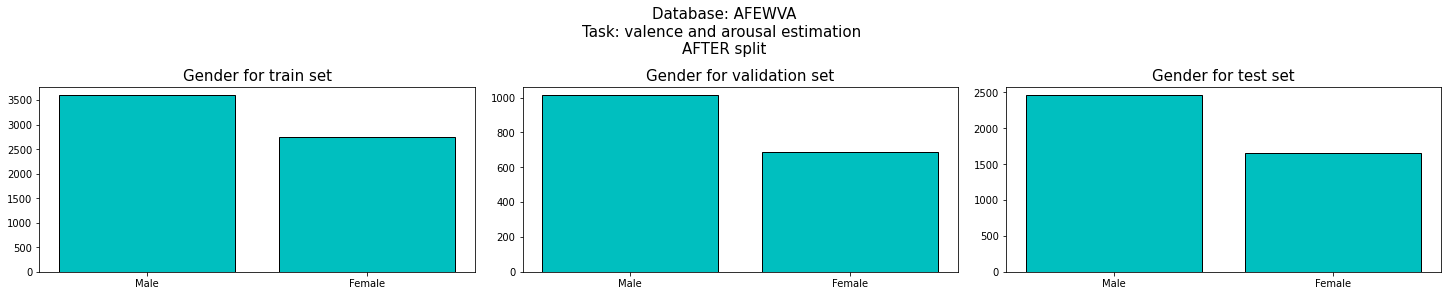

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train_fair[df_train_fair['gender']==gender_names[i]]))

gender_counter_val = []
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_validation_fair[df_validation_fair['gender']==gender_names[i]]))

gender_counter_test = []
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test_fair[df_test_fair['gender']==gender_names[i]]))

plot_samples('Gender',gender_names,gender_counter_train,gender_counter_val,gender_counter_test)


In [ ]:
print(gender_counter_train)
print(gender_counter_val)
print(gender_counter_test)

[3595, 2750]
[1012, 689]
[2458, 1653]


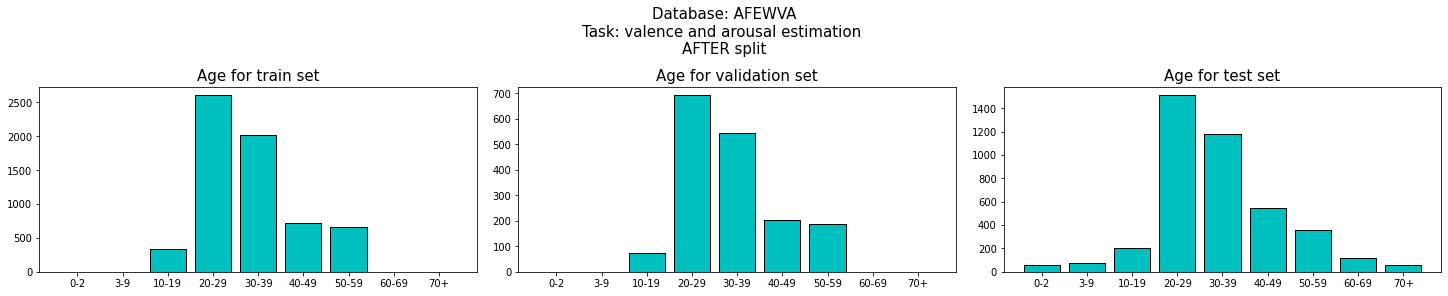

In [ ]:

age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train_fair[df_train_fair['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_validation_fair[df_validation_fair['age']==age_names[i]]))

age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test_fair[df_test_fair['age']==age_names[i]]))

plot_samples('Age',age_names,age_counter_train,age_counter_val,age_counter_test)


In [ ]:
print(age_counter_train)
print(age_counter_val)
print(age_counter_test)

[0, 0, 330, 2602, 2020, 725, 668, 0, 0]
[0, 0, 74, 691, 543, 204, 189, 0, 0]
[61, 77, 205, 1509, 1181, 544, 356, 119, 59]


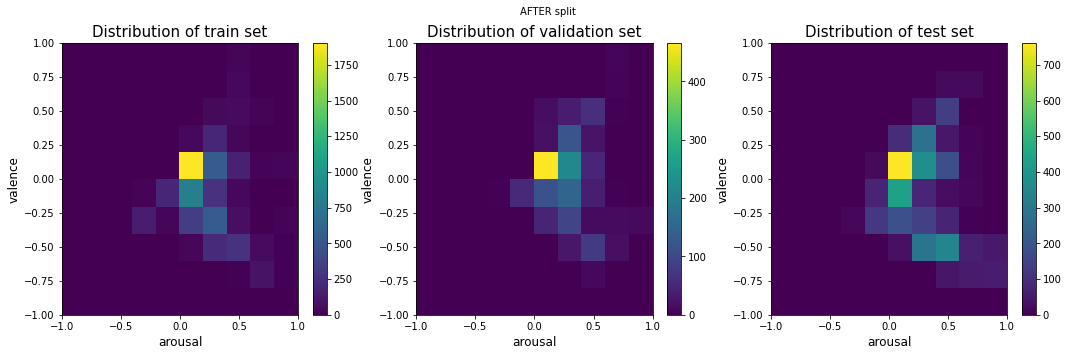

In [ ]:
show_v_a_distribution(df_train_fair,df_validation_fair,df_test_fair)

## data preprocessing 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)#,horizontal_flip=True,brightness_range=[0.2,1.0])
test_datagen = ImageDataGenerator(rescale=1./255)#,horizontal_flip=True,brightness_range=[0.2,1.0])

In [ ]:
batch_size = 128
#load and iterate training dataset
train_generator = train_datagen.flow_from_dataframe(
    df_train_fair,
    x_col='face_name_align',
    y_col=['valence','arousal'], #multitask
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw', #regression
    batch_size=batch_size
)
# load and iterate validation dataset
validation_generator = test_datagen.flow_from_dataframe(
    df_validation_fair,
    x_col='face_name_align',
    y_col=['valence','arousal'],
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
)

# load and iterate test dataset
test_generator = test_datagen.flow_from_dataframe(
    df_test_fair,
    x_col='face_name_align',
    y_col=['valence','arousal'],
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle = False
)


Found 6345 validated image filenames.
Found 1701 validated image filenames.
Found 4111 validated image filenames.


## training

In [ ]:
#pretrained model 
base_model =  tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_shape=(112,112,3),
    pooling='avg',
)

#use functional API to allow multiple outputs
# input shape
inputs = tf.keras.Input(shape=(112, 112, 3))
# model architecture
x = base_model(inputs, training=True)
#x = Dense(512, activation="relu")(x)
#x = Dropout(0.2)(x)
#x = Dense(512,activation= "relu")(x)

#output --> 2 tasks: valence & arousal
outputs = tf.keras.layers.Dense(2,activation="linear")(x) #change to tanh and see results
model = tf.keras.Model(inputs, outputs)
  

In [ ]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss= concordance_cc2_loss) 
                     # metrics=['mae',pearson_r] mean absolute error, Pearsons Correlation Coefficient

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 112, 112, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#checkpoint
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/AFEW-VA/AFEW-VA_simple/AFEWVA_before_lr4_b128/AFEWVA-{epoch:02d}.h5"

checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = model.fit(train_generator,validation_data=validation_generator,epochs=20,callbacks=callbacks_list)


## evaluation


In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/AFEW-VA/AFEW-VA_simple/AFEWVA_before_lr4_b128'
for saved_model in (os.listdir(models_directory)):
  if saved_model != '.ipynb_checkpoints':
    print(saved_model)
    model = tf.keras.models.load_model(os.path.join(models_directory,saved_model),custom_objects={'concordance_cc2_loss':concordance_cc2_loss})
    models_labels[saved_model[:-3]] = test_generator.labels
    models_predictions[saved_model[:-3]] = model.predict(test_generator)


In [ ]:
for model_name in models_labels.keys():
  
  valence_labels= []
  valence_predictions = []
  arousal_labels = []
  arousal_predictions = []

  labels,predictions = models_labels[model_name],models_predictions[model_name]
  valence_labels,valence_predictions,arousal_labels,arousal_predictions = valence_arousal(labels,predictions)

  print("Model Name: =",model_name)
  correlation_v,mse_v,mae_v = correlation_mse_mae(valence_labels,valence_predictions)
  correlation_a,mse_a,mae_a = correlation_mse_mae(arousal_labels,arousal_predictions)
  data = [["Correlation",correlation_v,correlation_a],["Mean Squared Error",mse_v,mse_a],["Mean Absolute Error",mae_v,mae_a]]
  print(tabulate(data, headers=[" Valence","Arousal"]))
  print('\n\n')

In [ ]:
best_model_name = 'AFEWVA-06'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)),custom_objects={'concordance_cc2_loss':concordance_cc2_loss})


In [ ]:
y_true_race,y_pred_race,counter_race = predictions_labels_category(test_generator,df_test_fair,
                                                      models_labels[best_model_name],models_predictions[best_model_name],
                                                      RACES,'race')

y_true_age,y_pred_age,counter_age = predictions_labels_category(test_generator,df_test_fair,
                                                    models_labels[best_model_name],models_predictions[best_model_name],
                                                    AGES,'age')

y_true_gender,y_pred_gender,counter_gender = predictions_labels_category(test_generator,df_test_fair,
                                                          models_labels[best_model_name],models_predictions[best_model_name],
                                                          GENDERS,'gender')


In [ ]:
print("OVERALL scores after split")
print("Batch size = 64 , learning rate = 0.001")
labels,predictions = models_labels[best_model_name],models_predictions[best_model_name]
v_l,v_p,a_l,a_p = valence_arousal(labels,predictions)
data = [["Correlation",correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0]]]
print(tabulate(data, headers=[" Valence","Arousal"]))
print()
results_category_nomse(df_test_fair,'after',RACES,'race',y_true_race,y_pred_race,counter_race)
results_category_nomse(df_test_fair,'after',AGES,'age',y_true_age,y_pred_age,counter_age)
results_category_nomse(df_test_fair,'after',GENDERS,'gender',y_true_gender,y_pred_gender,counter_gender)


OVERALL scores after split
Batch size = 64 , learning rate = 0.001
                Valence    Arousal
-----------  ----------  ---------
Correlation    0.022878   0.143846

race scores after split
race      #videos    #frames    Correlation    Correlation
                                    Valence        Arousal
------  ---------  ---------  -------------  -------------
White          78       3446      0.0228852      0.152472
Black           4        285     -0.0607095      0.0759697
Asian           6        329      0.0579511      0.147548
Indian          2         51      0             -0.483069

age scores after split
age      #videos    #frames    Correlation    Correlation
                                   Valence        Arousal
-----  ---------  ---------  -------------  -------------
0-2            1         61    -0.0199196       0.190939
3-9            1         77     0.00831462     -0.036848
10-19          5        205     0.242293        0.197574
20-29         36       1